In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Images we will resized as specified below.

In [3]:
IMG_SIZE = 250

#### Directory where images from epicurious.com will be downloaded.

In [4]:
ok_images='data/downloads/ok'

#### Directory where images from food.com will be downloaded.

In [5]:
nok_images='data/downloads/nok'

#### Creating an array of images already pre-processed and ready to fit a model. Array is normalized.

Note that we stack first the 'good' images, then the 'bad' ones.

In [6]:
X = np.vstack((dl_functions.normalize_images_array(ok_images, IMG_SIZE), dl_functions.normalize_images_array(nok_images, IMG_SIZE)))

#### Creating an array of labels.
Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [7]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

#### Creating a train, test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [9]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [10]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

In [11]:
model_1 = dl_functions.cnn_model_v_0(IMG_SIZE)

In [12]:
model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 248, 248, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
__________

In [ ]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

In [15]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

6/6 [==============================] - 1s


In [16]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 5.3727
Test accuracy: 66.67%


#### Creating a list of predictions.

In [17]:
predicted_images = []
for i in model_1.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:215: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


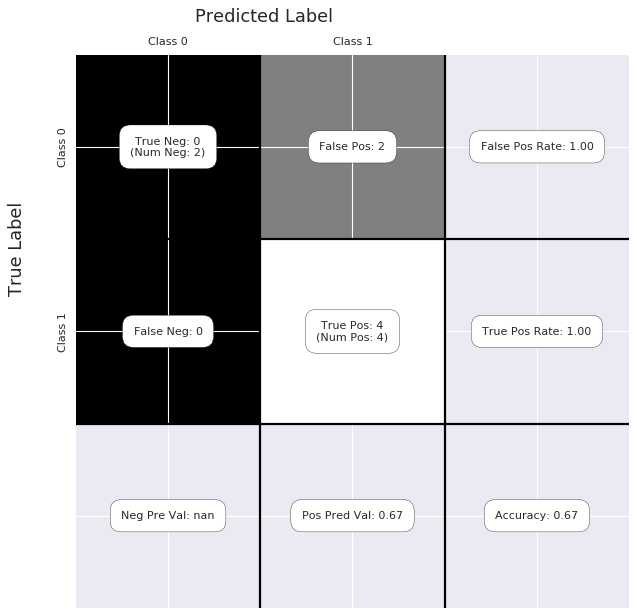

In [18]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [19]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,0,2
1,0,4


In [20]:
predictions_probability = model_1.predict_proba(X_test)

6/6 [==============================] - 1s


#### Plotting a ROC curve.

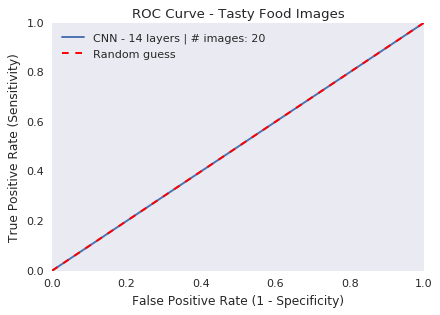

In [21]:
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [22]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [23]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [24]:
trump_prediction[0]

1

In [25]:
trump.shape

(1, 250, 250, 3)

In [26]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as good.

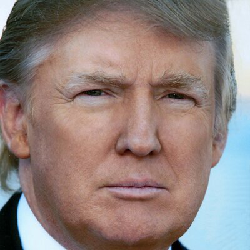

In [27]:
img = array_to_img(trump)
display(img)